In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [13]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import wandb as wb
import matplotlib.pyplot as plt
print(wb.__version__)

0.17.7


In [45]:
import librosa.display
import IPython.display as ipd

---

In [39]:
# load csv file
metadata = pd.read_csv('urbansound8k/UrbanSound8K.csv')
print(metadata.size)
metadata.head()

69856


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [29]:
row = metadata.iterrows()

In [44]:
index, rows = next(row)
print(index)
print(rows)
print("slice_file_name, folder, classID :", rows["slice_file_name"] ,rows['fold'], rows['classID'])

8
slice_file_name    100263-2-0-36.wav
fsID                          100263
start                           18.0
end                             22.0
salience                           1
fold                               5
classID                            2
class               children_playing
Name: 8, dtype: object
slice_file_name, folder, classID : 100263-2-0-36.wav 5 2


In [53]:
audio_dir = 'urbansound8k/fold1'
list_file = os.listdir(audio_dir)
print(list_file)

['135776-2-0-49.wav', '46654-6-0-0.wav', '57320-0-0-24.wav', '134717-0-0-26.wav', '174276-7-5-0.wav', '180937-7-2-6.wav', '17913-4-0-1.wav', '103074-7-4-6.wav', '176787-5-0-9.wav', '55020-4-0-11.wav', '138015-3-0-7.wav', '180937-7-0-4.wav', '180937-7-1-13.wav', '157867-8-0-10.wav', '103074-7-2-0.wav', '113205-5-1-4.wav', '57584-4-0-8.wav', '118279-8-0-8.wav', '137156-9-0-73.wav', '165645-4-1-0.wav', '182800-2-2-0.wav', '103074-7-0-2.wav', '159738-8-0-1.wav', '180937-7-4-0.wav', '164053-8-1-0.wav', '159738-8-0-0.wav', '132016-9-0-11.wav', '182800-2-2-1.wav', '180937-7-3-17.wav', '125791-3-0-9.wav', '108041-9-0-9.wav', '197318-6-1-0.wav', '118279-8-0-9.wav', '191431-9-0-8.wav', '139951-9-0-33.wav', '113205-5-1-5.wav', '180937-7-1-12.wav', '180937-7-0-5.wav', '157867-8-0-11.wav', '99180-9-0-7.wav', '176787-5-0-8.wav', '55020-4-0-10.wav', '192124-2-0-0.wav', '98223-7-1-0.wav', '17913-4-0-0.wav', '134717-0-0-27.wav', '72261-3-0-23.wav', '180937-7-2-7.wav', '143651-2-0-0.wav', '57320-0-0-31.

In [57]:
os.path.join(audio_dir, np.random.choice(list_file, 1)[0])

'urbansound8k/fold1/98223-7-0-0.wav'

(88200,) 22050


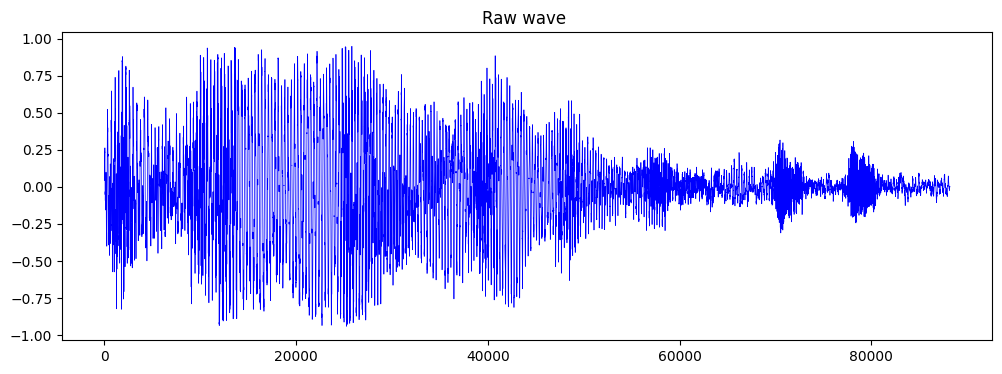

In [88]:
# selec random audio file
rnd_file = os.path.join(audio_dir, np.random.choice(list_file, 1)[0])

y , sr = librosa.load(rnd_file)
print(y.shape, sr)

# plot y array
plt.figure(figsize=(12, 4))
plt.plot(y, color='b', label='y', linewidth=0.5)
plt.title('Raw wave ')
plt.show()

# play random audio file
#ipd.Audio(rnd_file)
ipd.Audio(y, rate=sr)

D shape (1025, 173)
S shape (1025, 173)


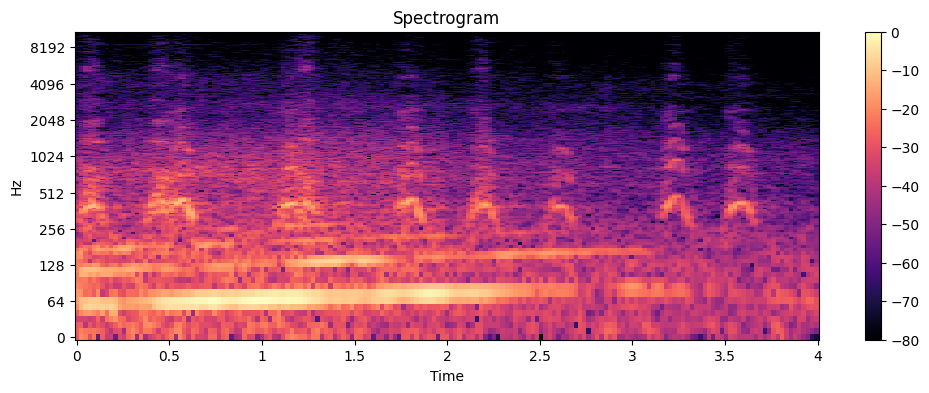

In [90]:
# STFT -> Short-time Fourier Transform on audio file
D = librosa.stft(y)
print("D shape", D.shape)

S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
print("S shape", S_db.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Spectrogram')
plt.show()

---

In [4]:
def load_data(data_path, metadata_path):
    """
    Load the UrbanSound8K dataset from the given data_path and metadata_path
    """

    features = []
    labels = []


    metadata = pd.read_csv(metadata_path)


    for index, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"fold{row['fold']}", f"{row['slice_file_name']}")


        # Load the audio file and resample it
        target_sr = 22050
        audio, sample_rate = librosa.load(file_path, sr=target_sr)


        # Extract MFCC features. Mel-frequency cepstral coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)


        # Append features and labels
        features.append(mfccs_scaled)
        labels.append(row['class'])


    return np.array(features), np.array(labels)


In [5]:
# !kaggle datasets download -d chrisfilo/urbansound8k

classID: </br>
A numeric identifier of the sound class: </br>
0 = air_conditioner </br>
1 = car_horn </br>
2 = children_playing </br>
3 = dog_bark </br>
4 = drilling </br>
5 = engine_idling </br>
6 = gun_shot </br>
7 = jackhammer </br>
8 = siren </br>
9 = street_music </br>

In [6]:
data_path = "urbansound8k"
metadata_path = "urbansound8k/UrbanSound8K.csv"
features, labels = load_data(data_path, metadata_path)


# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


/Users/brncat/Downloads/AltaVerde/GitHub/voice_emotion_segmentation/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/brncat/Downloads/AltaVerde/GitHub/voice_emotion_segmentation/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/brncat/Downloads/AltaVerde/GitHub/voice_emotion_segmentation/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [38]:
print(features.shape, labels_onehot.shape)

(8732, 40) (8732, 10)


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_onehot, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels_onehot)

In [8]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
def make_predictions(model, le, file_path):
    audio, sample_rate = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    features = mfccs_scaled.reshape(1, mfccs_scaled.shape[0], 1)
    predicted_vector = model.predict(features)
    predicted_class_index = np.argmax(predicted_vector, axis=-1)
    return le.inverse_transform(predicted_class_index)[0]


In [12]:
modelfit = model.fit(X_train, y_train, batch_size=32, epochs=100, 
          validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
219/219 [==============================] - 1s 5ms/step - loss: 2.5822 - accuracy: 0.3306 - val_loss: 1.3312 - val_accuracy: 0.5655
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 1.4511 - accuracy: 0.4989 - val_loss: 1.0707 - val_accuracy: 0.6732
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 1.2389 - accuracy: 0.5805 - val_loss: 0.9475 - val_accuracy: 0.7035
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 1.0922 - accuracy: 0.6316 - val_loss: 0.7540 - val_accuracy: 0.7733
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.9688 - accuracy: 0.6764 - val_loss: 0.7069 - val_accuracy: 0.7785
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.8664 - accuracy: 0.7084 - val_loss: 0.6373 - val_accuracy: 0.7974
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 0.7999 - accuracy: 0.7336 - val_loss: 0.5887 - val_accuracy: 0.8203

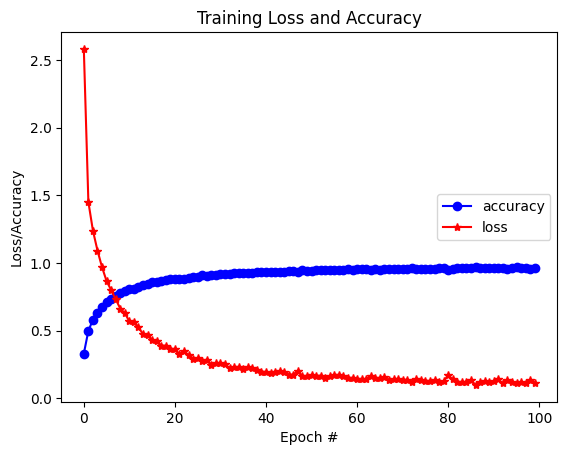

In [14]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(modelfit.history['accuracy'], '-bo', label="accuracy")
plt.plot(modelfit.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [16]:
# evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {accuracy*100:.2f}%')

Test loss: 0.34
Test accuracy: 93.30%


---

# Speech Recognition

### Python program to translate speech to text and text to speech

In [1]:
import speech_recognition as sr
import pyttsx3 

In [2]:
# Initialize the recognizer 
r = sr.Recognizer() 

In [3]:
# Function to convert text to
# speech
def SpeakText(command):
    
    # Initialize the engine
    engine = pyttsx3.init()
    engine.say(command) 
    engine.runAndWait()

In [5]:
# Loop infinitely for user to
# speak

while(1):    
    
    # Exception handling to handle
    # exceptions at the runtime
    try:
        
        # use the microphone as source for input.
        with sr.Microphone() as source2:
            
            # wait for a second to let the recognizer
            # adjust the energy threshold based on
            # the surrounding noise level 
            r.adjust_for_ambient_noise(source2, duration=0.2)
            
            #listens for the user's input 
            audio2 = r.listen(source2)
            
            # Using google to recognize audio
            MyText = r.recognize_google(audio2)
            MyText = MyText.lower()

            print("Did you say ", MyText)
            SpeakText(MyText)
            
    except sr.RequestError as e:
        print("Could not request results; {0}".format(e))
        
    except sr.UnknownValueError:
        print("unknown error occurred")

AttributeError: Could not find PyAudio; check installation